In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


In [14]:
file_path = 'data_selection_17_23.csv'
data = pd.read_csv(file_path)
data['timestamp'] = (data['timestamp'] - 1468800) // 30

data.head(100)

,timestamp,nodeid,temperature,humidity,voltage,light
0,0,1,NaN,NaN,NaN,NaN
1,0,2,NaN,NaN,NaN,NaN
2,0,3,NaN,NaN,NaN,NaN
3,0,4,NaN,NaN,NaN,NaN
4,0,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
95,1,42,NaN,NaN,NaN,NaN
96,1,43,NaN,NaN,NaN,NaN
97,1,44,NaN,NaN,NaN,NaN
98,1,45,NaN,NaN,NaN,NaN


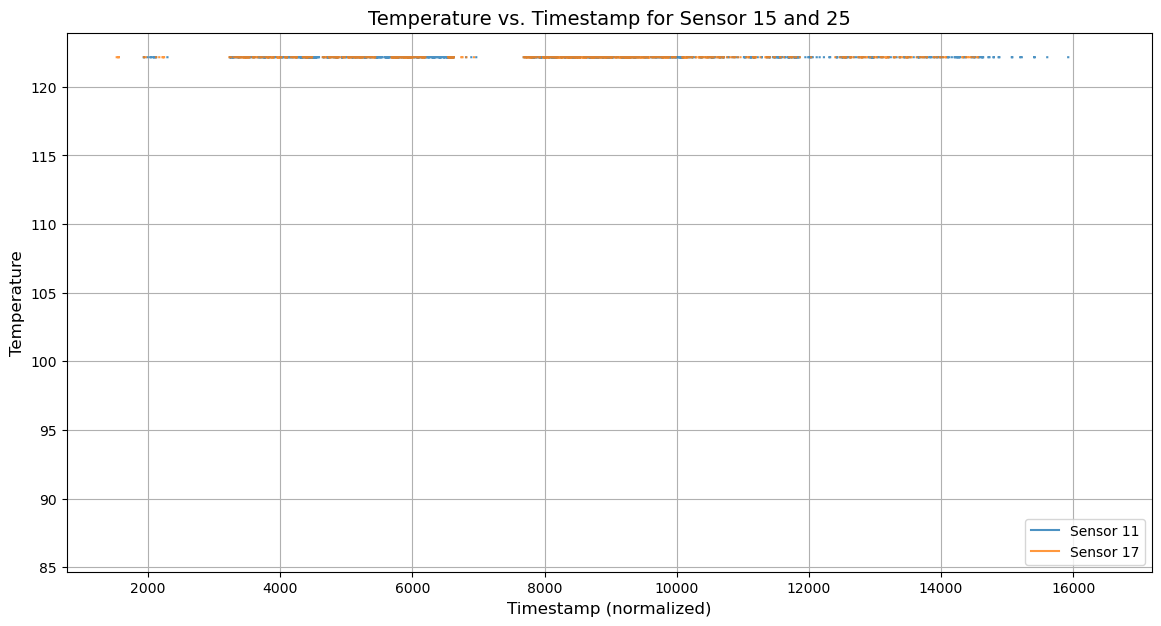

In [29]:
# Filter data for sensors 15 and 25
sensor_15_data = data[data['nodeid'] == 16]
sensor_25_data = data[data['nodeid'] == 17]

# Plot temperature vs. timestamp for both sensors
plt.figure(figsize=(14, 7))
plt.plot(sensor_15_data['timestamp'], sensor_15_data['temperature'], label='Sensor 11', alpha=0.8)
plt.plot(sensor_25_data['timestamp'], sensor_25_data['temperature'], label='Sensor 17', alpha=0.8)

# Add labels, title, and legend
plt.xlabel('Timestamp (normalized)', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.title('Temperature vs. Timestamp for Sensor 15 and 25', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Focus on temperature data, dropping NaN values for proper analysis
temperature_data = data[['timestamp', 'temperature']].dropna()

# Perform seasonal decomposition to analyze trend, seasonality, and residuals
decomposition = seasonal_decompose(temperature_data['temperature'], model='additive', period=24)

# Define threshold for anomalies based on residuals (e.g., 2 standard deviations)
residuals = decomposition.resid.dropna()
threshold = 2 * np.std(residuals)

# Ensure that the residual indices are correctly mapped to the temperature data
temperature_data = temperature_data.loc[residuals.index]  # Align based on residual indices

# Identify anomalies where residuals exceed the defined threshold
temperature_data['anomaly'] = abs(residuals) > threshold

# Create a new DataFrame to store only the anomaly data points
anomaly_data = temperature_data[temperature_data['anomaly']]

# Save the anomaly data to a new file
anomaly_file_path = 'temperature_anomalies.csv'
anomaly_data.to_csv(anomaly_file_path, index=False)

print(f"Anomaly data saved to: {anomaly_file_path}")

Anomaly data saved to: temperature_anomalies.csv


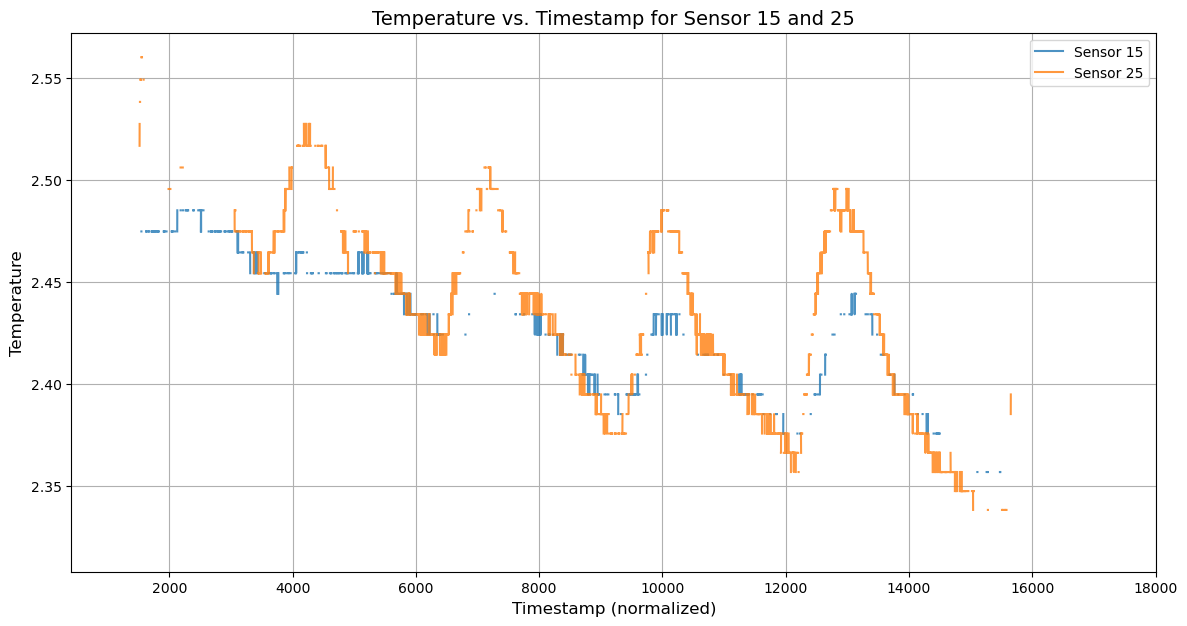

In [17]:
# Filter the data for sensor 31
sensor_31_data = data[data['nodeid'] == 31]

# Check how many temperature points are anomaly vs normal
sensor_31_data['anomaly'] = sensor_31_data['temperature'].apply(
    lambda x: abs(x - decomposition.trend.mean()) > threshold if not pd.isna(x) else False
)

# Count anomalies and normal data points
anomaly_count = sensor_31_data['anomaly'].sum()
normal_count = sensor_31_data.shape[0] - anomaly_count

anomaly_count, normal_count


C:\Users\jianger\AppData\Local\Temp\ipykernel_13860\1822959251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_31_data['anomaly'] = sensor_31_data['temperature'].apply(


(0, 17280)

In [21]:
# Optimize anomaly detection by precomputing residuals for temperature
residuals = decomposition.resid.dropna()  # Already computed residuals
temperature_threshold = 2 * np.std(residuals)

# Align residuals with the data
temperature_data = data[['nodeid', 'temperature']].dropna()
temperature_data = temperature_data.loc[residuals.index]
temperature_data['anomaly'] = abs(residuals) > temperature_threshold

# Count anomalies and normal points for each sensor
sensor_summary = temperature_data.groupby('nodeid').agg(
    Anomalous_Points=('anomaly', 'sum'),
    Total_Points=('temperature', 'count')
)
sensor_summary['Normal_Points'] = sensor_summary['Total_Points'] - sensor_summary['Anomalous_Points']
sensor_summary['Anomaly_Percentage (%)'] = (sensor_summary['Anomalous_Points'] / sensor_summary['Total_Points']) * 100

sensor_summary

# # Display the summary table to the user
# tools.display_dataframe_to_user(name="Sensor Temperature Anomaly Statistics", dataframe=sensor_summary)

,Anomalous_Points,Total_Points,Normal_Points,Anomaly_Percentage (%)
nodeid,,,,
1,0,3629,3629,0.000000
2,0,5385,5385,0.000000
3,0,4381,4381,0.000000
4,5,3410,3405,0.146628
6,549,2533,1984,21.673904
7,0,3628,3628,0.000000
9,0,3236,3236,0.000000
10,0,2502,2502,0.000000
11,0,2770,2770,0.000000
